In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score

# Load the dataset
df = pd.read_csv('Frogs_MFCCs.csv')


In [2]:
# Basic EDA
print("Dataset Info:")
print(df.info())  # Checking for missing values, data types, etc.

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7195 entries, 0 to 7194
Data columns (total 26 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   MFCCs_ 1  7195 non-null   float64
 1   MFCCs_ 2  7195 non-null   float64
 2   MFCCs_ 3  7195 non-null   float64
 3   MFCCs_ 4  7195 non-null   float64
 4   MFCCs_ 5  7195 non-null   float64
 5   MFCCs_ 6  7195 non-null   float64
 6   MFCCs_ 7  7195 non-null   float64
 7   MFCCs_ 8  7195 non-null   float64
 8   MFCCs_ 9  7195 non-null   float64
 9   MFCCs_10  7195 non-null   float64
 10  MFCCs_11  7195 non-null   float64
 11  MFCCs_12  7195 non-null   float64
 12  MFCCs_13  7195 non-null   float64
 13  MFCCs_14  7195 non-null   float64
 14  MFCCs_15  7195 non-null   float64
 15  MFCCs_16  7195 non-null   float64
 16  MFCCs_17  7195 non-null   float64
 17  MFCCs_18  7195 non-null   float64
 18  MFCCs_19  7195 non-null   float64
 19  MFCCs_20  7195 non-null   float64
 20  MFCCs_21  7195 n

In [3]:
# Statistical overview
print("Dataset Description:")
print(df.describe())



Dataset Description:
          MFCCs_ 1     MFCCs_ 2     MFCCs_ 3     MFCCs_ 4     MFCCs_ 5  \
count  7195.000000  7195.000000  7195.000000  7195.000000  7195.000000   
mean      0.989885     0.323584     0.311224     0.445997     0.127046   
std       0.069016     0.218653     0.263527     0.160328     0.162722   
min      -0.251179    -0.673025    -0.436028    -0.472676    -0.636012   
25%       1.000000     0.165945     0.138445     0.336737     0.051717   
50%       1.000000     0.302184     0.274626     0.481463     0.161361   
75%       1.000000     0.466566     0.430695     0.559861     0.222592   
max       1.000000     1.000000     1.000000     1.000000     0.752246   

          MFCCs_ 6     MFCCs_ 7     MFCCs_ 8     MFCCs_ 9     MFCCs_10  ...  \
count  7195.000000  7195.000000  7195.000000  7195.000000  7195.000000  ...   
mean      0.097939    -0.001397    -0.000370     0.128213     0.055998  ...   
std       0.120412     0.171404     0.116302     0.179008     0.127099  ...

In [4]:


# Data Scaling
features = df.iloc[:, :-4]  # Exclude non-MFCC columns like species, genus, etc.
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Feature Engineering: Generate Polynomial and Interaction Terms
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
poly_features = poly.fit_transform(scaled_features)

print("Original Features Shape:", scaled_features.shape)
print("Shape after Feature Engineering:", poly_features.shape)

poly_features_df = pd.DataFrame(poly_features)



Original Features Shape: (7195, 22)
Shape after Feature Engineering: (7195, 253)


In [ ]:
# Feature Correlation Analysis
# Calculate the correlation matrix
corr_matrix = poly_features_df.corr().abs()

# Select the upper triangle of the correlation matrix
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than a threshold (e.g., 0.9)
high_corr_features = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.9)]

# Drop highly correlated features
reduced_features_df = poly_features_df.drop(columns=high_corr_features)
print("Shape after removing highly correlated features:", reduced_features_df.shape)

In [6]:
# Proceed with K-Means clustering on the reduced feature set
reduced_features = reduced_features_df.values  # Convert back to array for clustering

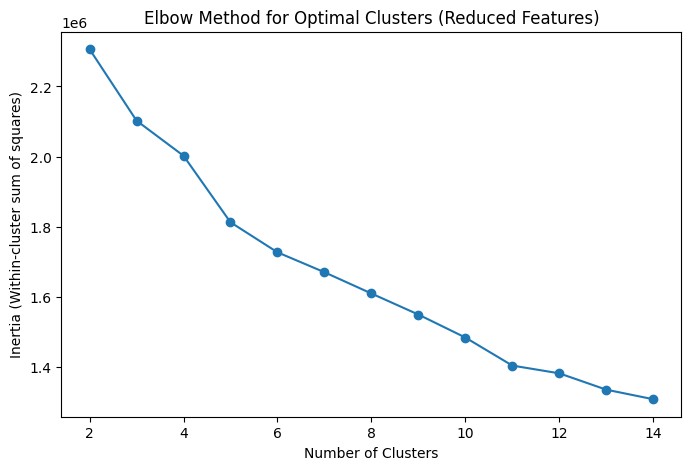

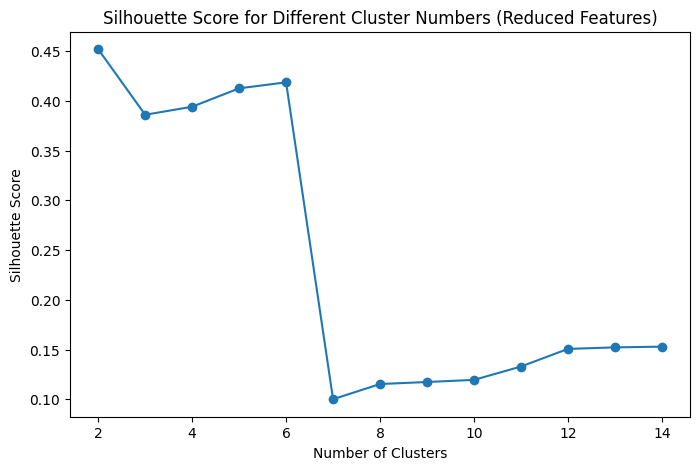

Optimal number of clusters: 2
Initialization method: random
Inertia (Within-cluster sum of squares): 2298663.7367058285
Silhouette Score: 0.3620787555007739
------------------------------
Initialization method: k-means++
Inertia (Within-cluster sum of squares): 2306114.488414889
Silhouette Score: 0.4520609391685119
------------------------------


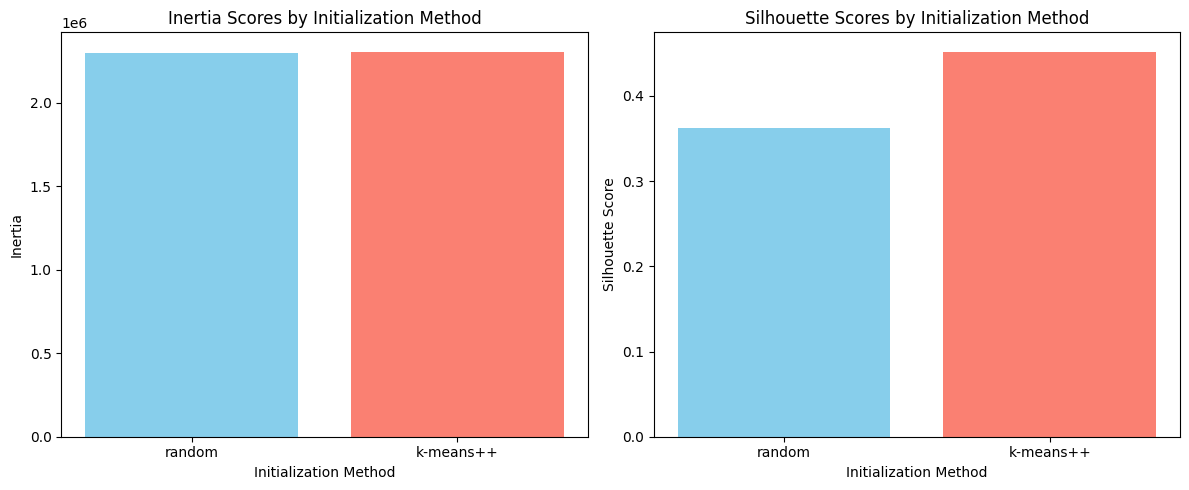

Silhouette Score: 0.4520609391685119


In [7]:
# K-Means clustering and evaluation
inertia = []
cluster_range = range(2, 15)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(reduced_features)
    inertia.append(kmeans.inertia_)

# Plot Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, inertia, marker='o')
plt.title("Elbow Method for Optimal Clusters (Reduced Features)")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia (Within-cluster sum of squares)")
plt.show()

# Silhouette Score to validate cluster choice
silhouette_scores = []
db_scores = []
ch_scores = []

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    cluster_labels = kmeans.fit_predict(reduced_features)
    silhouette_scores.append(silhouette_score(reduced_features, cluster_labels))
    db_scores.append(davies_bouldin_score(reduced_features, cluster_labels))
    ch_scores.append(calinski_harabasz_score(reduced_features, cluster_labels))

# Plot Silhouette Score
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.title("Silhouette Score for Different Cluster Numbers (Reduced Features)")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.show()

# Choosing the optimal number of clusters based on Silhouette Score and Elbow Method
optimal_k = cluster_range[silhouette_scores.index(max(silhouette_scores))]
print("Optimal number of clusters:", optimal_k)

# Comparing different initialization methods for K-Means
initializations = ['random', 'k-means++']
inertia_scores = {}
silhouette_scores_init = {}

for init in initializations:
    kmeans = KMeans(n_clusters=optimal_k, init=init, random_state=42)
    clusters = kmeans.fit_predict(reduced_features)
    inertia_scores[init] = kmeans.inertia_
    silhouette_scores_init[init] = silhouette_score(reduced_features, clusters)
    
    print(f"Initialization method: {init}")
    print(f"Inertia (Within-cluster sum of squares): {kmeans.inertia_}")
    print(f"Silhouette Score: {silhouette_scores_init[init]}")
    print("-" * 30)

# Visualizing the Inertia and Silhouette Scores for Different Initializations
plt.figure(figsize=(12, 5))

# Plot Inertia Scores
plt.subplot(1, 2, 1)
plt.bar(inertia_scores.keys(), inertia_scores.values(), color=['skyblue', 'salmon'])
plt.title("Inertia Scores by Initialization Method")
plt.xlabel("Initialization Method")
plt.ylabel("Inertia")

# Plot Silhouette Scores
plt.subplot(1, 2, 2)
plt.bar(silhouette_scores_init.keys(), silhouette_scores_init.values(), color=['skyblue', 'salmon'])
plt.title("Silhouette Scores by Initialization Method")
plt.xlabel("Initialization Method")
plt.ylabel("Silhouette Score")

plt.tight_layout()
plt.show()

# Final K-Means clustering with k-means++ initialization and optimal_k clusters
kmeans_final = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42)
clusters_final = kmeans_final.fit_predict(reduced_features)

# Calculate the silhouette score for the final clustering
silhouette_avg = silhouette_score(reduced_features, clusters_final)

print(f"Silhouette Score: {silhouette_avg}")


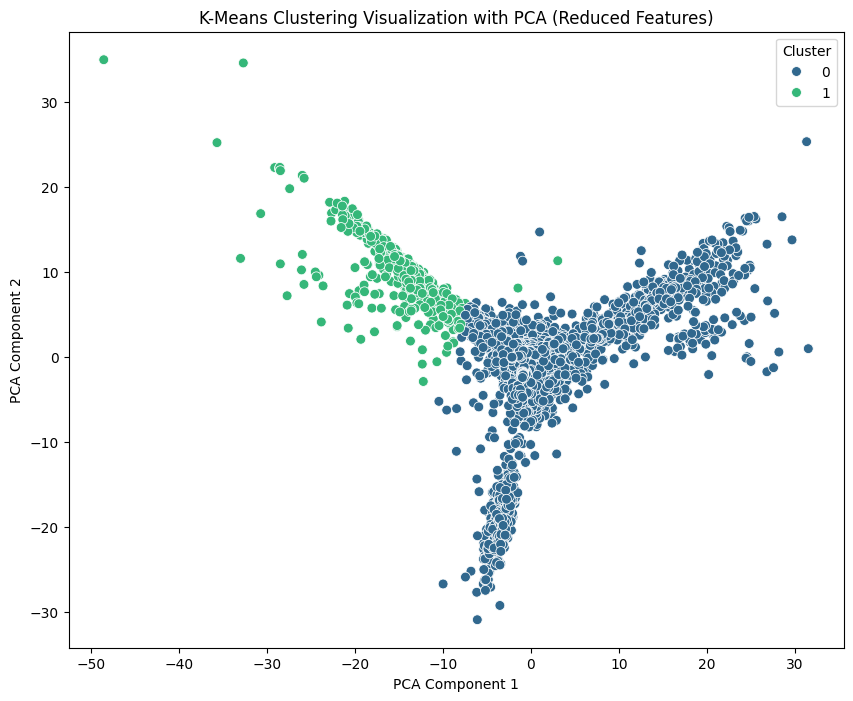

In [8]:
# Dimensionality Reduction with PCA for visualization
pca = PCA(n_components=2)
reduced_pca_features = pca.fit_transform(reduced_features)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=reduced_pca_features[:, 0], y=reduced_pca_features[:, 1], hue=clusters_final, palette="viridis", s=50)
plt.title("K-Means Clustering Visualization with PCA (Reduced Features)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.show()

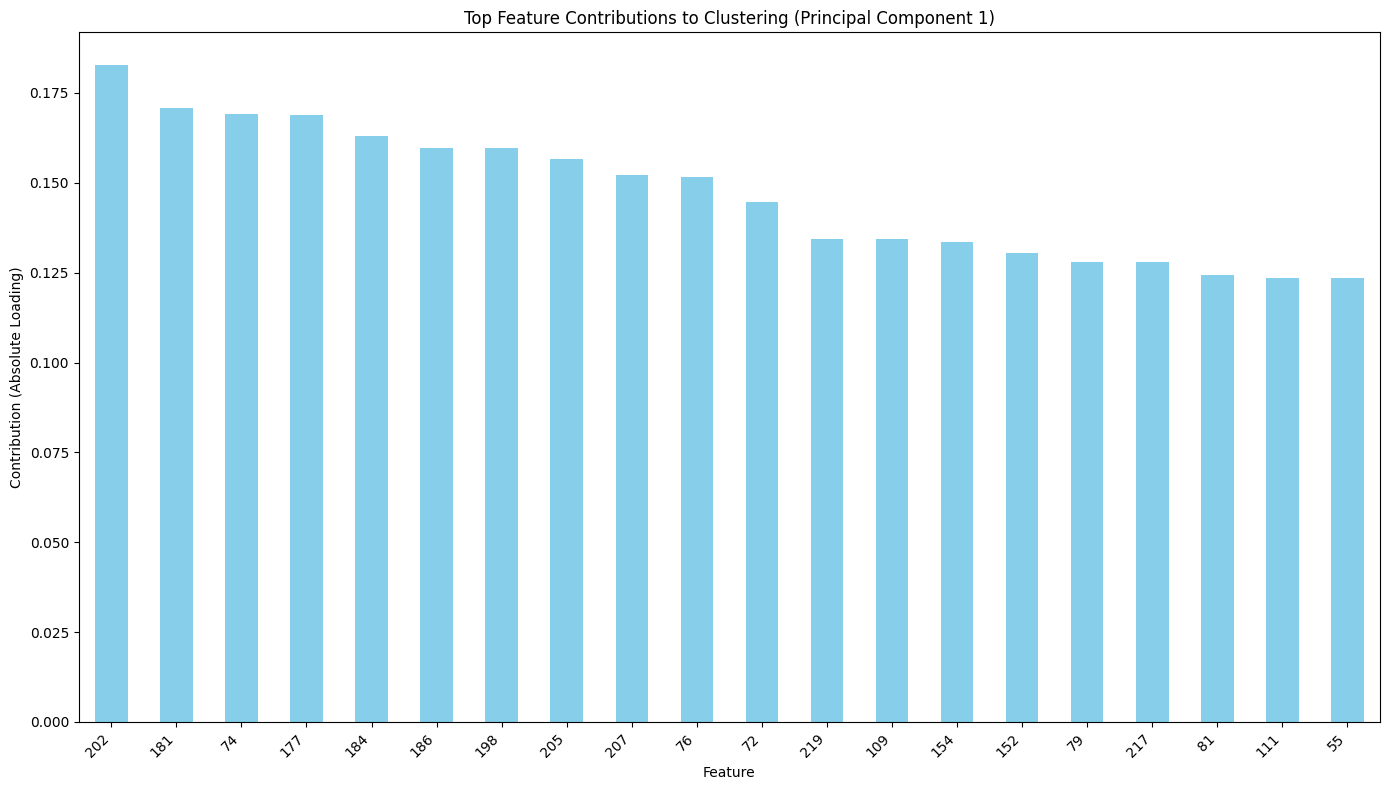

In [9]:
# Feature Contribution to Clustering: Principal Component Analysis (PCA)
# Fit PCA on reduced features to examine feature importance
pca_contribution = PCA(n_components=2)
pca_contribution.fit(reduced_features)
# Get the loadings of each feature on the principal components
pca_loadings = pd.DataFrame(pca_contribution.components_.T, index=reduced_features_df.columns, columns=['PC1', 'PC2'])

# Calculate the absolute values of the loadings to see the magnitude of contribution
pca_contributions = pca_loadings.abs()

# Visualize the contributions of features on the first principal component
plt.figure(figsize=(14, 8))
top_features_pc1 = pca_contributions['PC1'].sort_values(ascending=False).head(20)

top_features_pc1.plot(kind='bar', color='skyblue')
plt.title("Top Feature Contributions to Clustering (Principal Component 1)")
plt.xlabel("Feature")
plt.ylabel("Contribution (Absolute Loading)")
plt.xticks(rotation=45, ha='right')  # Rotate labels for readability
plt.tight_layout()  # Adjust layout to fit all elements
plt.show()

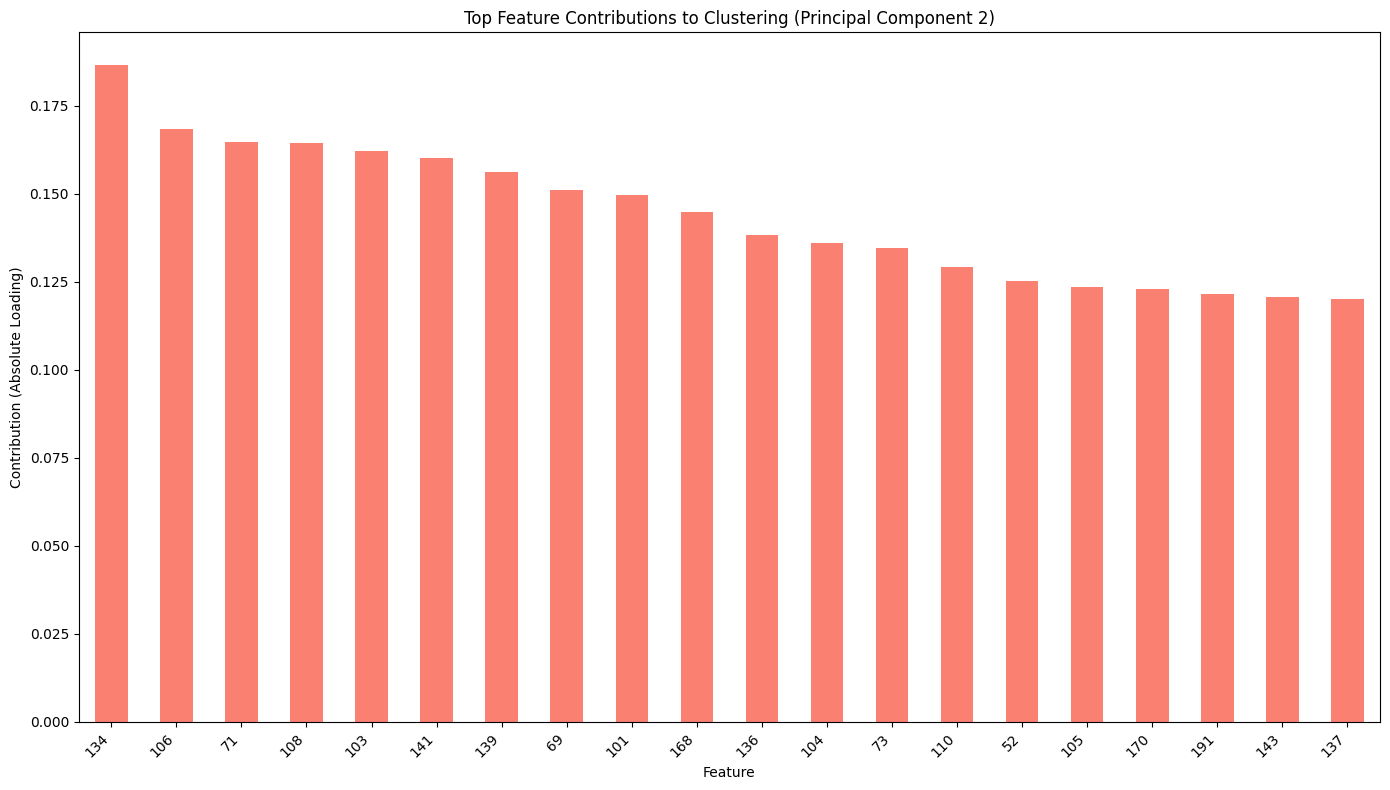

In [10]:
# top contributions for PC2
plt.figure(figsize=(14, 8))
top_features_pc2 = pca_contributions['PC2'].sort_values(ascending=False).head(20)

top_features_pc2.plot(kind='bar', color='salmon')
plt.title("Top Feature Contributions to Clustering (Principal Component 2)")
plt.xlabel("Feature")
plt.ylabel("Contribution (Absolute Loading)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

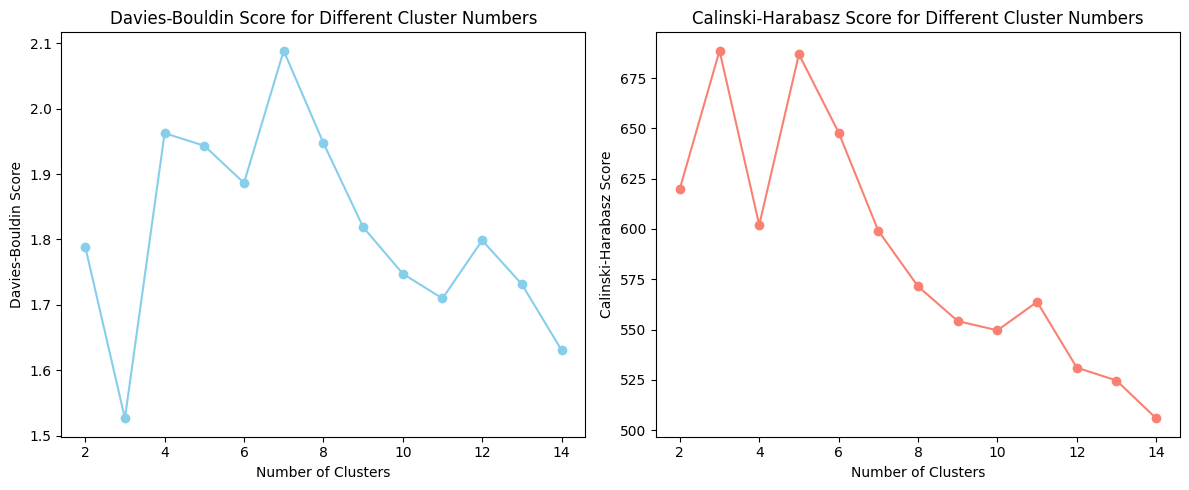

In [11]:
# Plot Davies-Bouldin and Calinski-Harabasz scores
plt.figure(figsize=(12, 5))

# Davies-Bouldin Score
plt.subplot(1, 2, 1)
plt.plot(cluster_range, db_scores, marker='o', color='skyblue')
plt.title("Davies-Bouldin Score for Different Cluster Numbers")
plt.xlabel("Number of Clusters")
plt.ylabel("Davies-Bouldin Score")

# Calinski-Harabasz Score
plt.subplot(1, 2, 2)
plt.plot(cluster_range, ch_scores, marker='o', color='salmon')
plt.title("Calinski-Harabasz Score for Different Cluster Numbers")
plt.xlabel("Number of Clusters")
plt.ylabel("Calinski-Harabasz Score")

plt.tight_layout()
plt.show()

In [12]:
# Additional Clustering Methods: Hierarchical Clustering and DBSCAN
# Hierarchical Clustering with optimal_k clusters
hierarchical = AgglomerativeClustering(n_clusters=optimal_k)
clusters_hierarchical = hierarchical.fit_predict(reduced_features)

# DBSCAN Clustering with chosen epsilon and min_samples
dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters_dbscan = dbscan.fit_predict(reduced_features)

# Add comparison of cluster counts for each clustering method
print("Number of clusters (K-Means):", len(set(clusters_final)) - (1 if -1 in clusters_final else 0))
print("Number of clusters (Hierarchical):", len(set(clusters_hierarchical)) - (1 if -1 in clusters_hierarchical else 0))
print("Number of clusters (DBSCAN):", len(set(clusters_dbscan)) - (1 if -1 in clusters_dbscan else 0))

Number of clusters (K-Means): 2
Number of clusters (Hierarchical): 2
Number of clusters (DBSCAN): 3


In [13]:
# Apply Agglomerative Clustering
agg_clustering = AgglomerativeClustering(n_clusters=optimal_k)
clusters_agg = agg_clustering.fit_predict(reduced_features)
#compute Agglomerative Clustering stats
silhouette_agg = silhouette_score(reduced_features, clusters_agg)
db_index_agg = davies_bouldin_score(reduced_features, clusters_agg)
ch_score_agg = calinski_harabasz_score(reduced_features, clusters_agg)

# Apply DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters_dbscan = dbscan.fit_predict(reduced_features)
#compute DBSCAN stats
# Exclude noise points for DBSCAN metrics
core_samples_mask = clusters_dbscan != -1  # mask to exclude noise points
if core_samples_mask.any():
    silhouette_dbscan = silhouette_score(reduced_features[core_samples_mask], clusters_dbscan[core_samples_mask])
    ch_score_dbscan = calinski_harabasz_score(reduced_features[core_samples_mask], clusters_dbscan[core_samples_mask])
else:
    silhouette_dbscan = ch_score_dbscan = None

# kmeans stats
silhouette_kmeans = silhouette_score(reduced_features, clusters_final)
db_index_kmeans = davies_bouldin_score(reduced_features, clusters_final)
ch_score_kmeans = calinski_harabasz_score(reduced_features, clusters_final)


#printing the stats
print("-" * 30)
print("K-Means Clustering Metrics:")
print(f"  Silhouette Score: {silhouette_kmeans:.4f}")
print(f"  Davies-Bouldin Index: {db_index_kmeans:.4f}")
print(f"  Calinski-Harabasz Score: {ch_score_kmeans:.4f}")
print("-" * 30)

print("Agglomerative Clustering Metrics:")
print(f"  Silhouette Score: {silhouette_agg:.4f}")
print(f"  Davies-Bouldin Index: {db_index_agg:.4f}")
print(f"  Calinski-Harabasz Score: {ch_score_agg:.4f}")
print("-" * 30)

print("DBSCAN Clustering Metrics (excluding noise):")
if silhouette_dbscan is not None:
    print(f"  Silhouette Score: {silhouette_dbscan:.4f}")
    print(f"  Calinski-Harabasz Score: {ch_score_dbscan:.4f}")
else:
    print("  Insufficient core points for Silhouette or Calinski-Harabasz Score calculation.")
print("  Davies-Bouldin Index is not applicable to DBSCAN due to noise.")
print("-" * 30)


------------------------------
K-Means Clustering Metrics:
  Silhouette Score: 0.4521
  Davies-Bouldin Index: 1.7890
  Calinski-Harabasz Score: 619.9921
------------------------------
Agglomerative Clustering Metrics:
  Silhouette Score: 0.3516
  Davies-Bouldin Index: 0.9923
  Calinski-Harabasz Score: 634.5719
------------------------------
DBSCAN Clustering Metrics (excluding noise):
  Silhouette Score: 0.4786
  Calinski-Harabasz Score: 36.3784
  Davies-Bouldin Index is not applicable to DBSCAN due to noise.
------------------------------


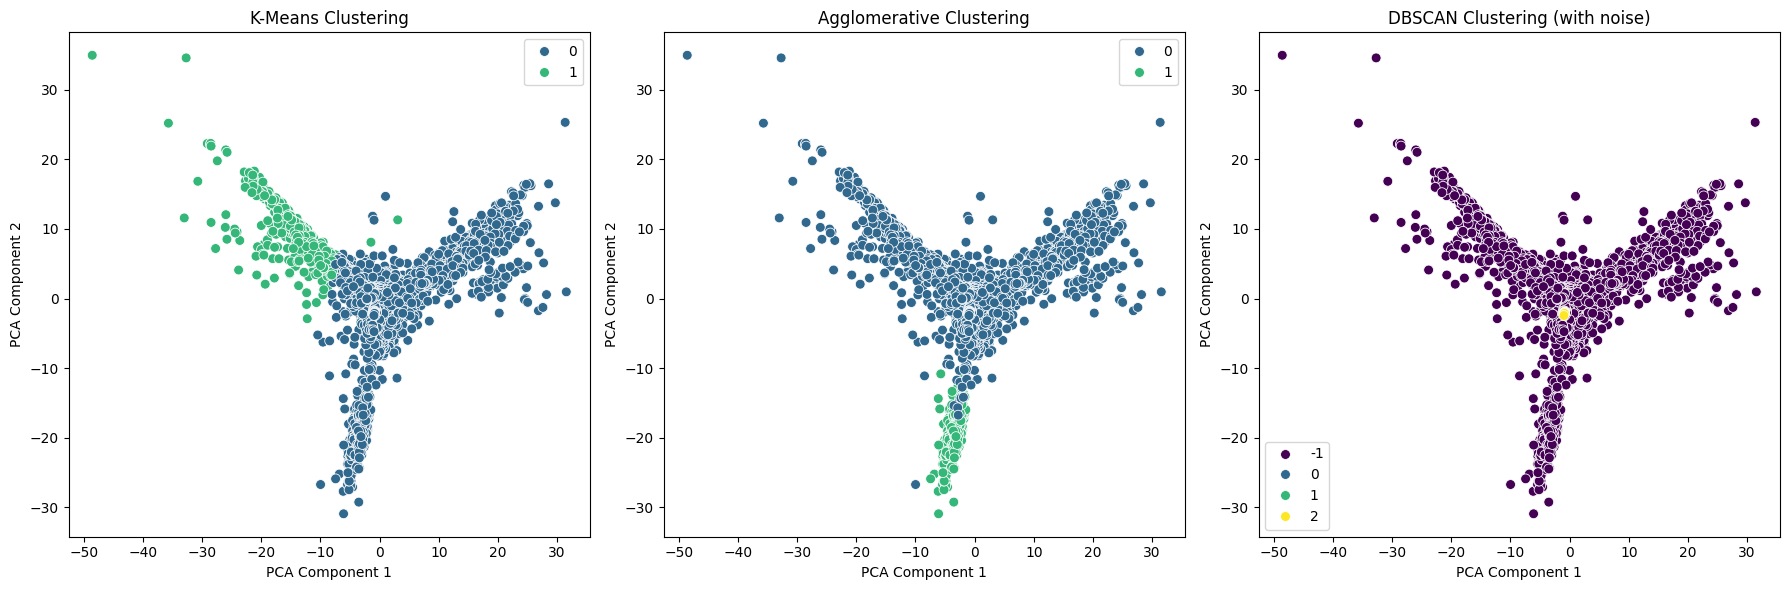

In [14]:
# Dimensionality Reduction with PCA for visualization (reused from above)
plt.figure(figsize=(18, 6))

# K-Means Clustering Visualization
plt.subplot(1, 3, 1)
sns.scatterplot(x=reduced_pca_features[:, 0], y=reduced_pca_features[:, 1], hue=clusters_final, palette="viridis", s=50)
plt.title("K-Means Clustering")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")

# Agglomerative Clustering Visualization
plt.subplot(1, 3, 2)
sns.scatterplot(x=reduced_pca_features[:, 0], y=reduced_pca_features[:, 1], hue=clusters_agg, palette="viridis", s=50)
plt.title("Agglomerative Clustering")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")

# DBSCAN Clustering Visualization
plt.subplot(1, 3, 3)
sns.scatterplot(x=reduced_pca_features[:, 0], y=reduced_pca_features[:, 1], hue=clusters_dbscan, palette="viridis", s=50)
plt.title("DBSCAN Clustering (with noise)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")

plt.tight_layout()
plt.show()
